# Neural Style Transfer Model


This is the preparation model for the 3 series neural network for detecting faces.

As the face detection and especially the emotion classifier are pretty standard models lets start with the trickiest bit which is the neural style image

In [15]:
! jupyter nbconvert --to script main_model.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook main_model.ipynb to script
[NbConvertApp] Writing 11943 bytes to main_model.py


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Set the device to CUDA as we need to perform a lot of GPU calculations to get the final output

In [2]:
device = torch.device('cuda')

### Create the image loader and the image shower

In [3]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image)[None]
    return image.to(device, torch.float)

In [4]:
unloader = transforms.ToPILImage()

plt.ion() # turn on interactive mode to show images immidiatly

In [5]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone() # clone to not modify the original image
    image = image[0]
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001) # pause to let the plots update

### Setting up the loss function
Here we will setup the loss function so that the randomly generated image is incentivised to have similar content to the content image while also having a similar style as the style image :)

In [6]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # detach the target (which is the content image) from the computational graph
        # this is needed so that the gradients used to obtain the target are not counted
        # we only wish to calculate the gradients comparing to the input image
        # and we treat the target as simple constants
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [7]:
def gram_matrix(input):
    a, b, c, d = input.size() #a - batch size = 1, b = number of feature maps / n_channels
                              # c, d = dimensions of each channel / feature map
    features = input.view(a * b, c * d) # resize input into n_c by n_h*n_w
    
    G = torch.mm(features, features.t())
    # "normalize" by dividing by total pixels to make earlier layers which have greater
    # height and width not be more impactful than later layers 
    return G / (a * b * c * d) 

In [8]:
class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # once again must detach from computation graph to treat the target as a constant
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G_in = gram_matrix(input)
        self.loss = F.mse_loss(G_in, self.target)
        return input

### Import the model
For this example we will follow the pytorch tutorial and use VGG19
We also only wish to use the features model which contains all the convolution and pool layers but none of the dense layers used in the final classification

In [9]:
# here we set it to eval mode as some layers perform diferently for training
# and we do not wish to modify anything in the model, we simply wish to use the model to 
# evaluate the feature maps of the 3 images at the different layers
cnn = models.vgg19(pretrained=True).features.to(device).eval()

As VGG networks are trained on images where all channgels are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] we will add an additional normalization layer for our images

In [10]:
# make normalization model in order to combine all with nn.Sequential later easily
cnn_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device) # per channel
cnn_norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device) # per channel
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # convert to tensors of shpae n_c, 1, 1 so that they can be broadcasted
        # onto images with m, n_c, n_h, n_w
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
        
    def forward(self, img):
        #norm image
        return (img - self.mean) / self.std

In [11]:
def get_style_model_and_losses(cnn, norm_mean, norm_std, style_img, content_img,
                          content_layers=content_layers_def, style_layers=style_layers_def):
    # assemble the model for the image generation
    # grab all the layers from VGG19 up to the last layer in the cont and style layers
    # and add in the loss functions which we want to minimize
    norm = Normalization(norm_mean, norm_std).to(device)
    
    # setup lists which will contain the loss functions for style and content per layer
    # so that we could iterate to get total loss
    content_losses = []
    style_losses = []
    
    # begin making the sequential model which will calculate the losses of style, 
    # content and target
    model = nn.Sequential(norm)
    
    i = 0 # count up at every conv layer
    for layer in cnn.children(): # iterate over all of the cnn layers
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            # inplace version does not work nicely with the Loss functions
            # threfore replace it with outofplace version
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            # TODO replace with average pool
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f"input model has unrecognized layer\
                                {layer.__class__.__name__}")
        model.add_module(name, layer) # add the layer to our model
        
        if name in content_layers:
            # add the content loss
            # first run forward prop on the current model stub and detach to treat
            # the target as a constant
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            # add style loss, first forward prop through model stub and detach target
            # to treat it as a constant
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)
    print(f'total conv layers:{i}')
    # now we trim off all the layers of the original model which are after the last
    # content or style loss layer in the model
    for i in range(len(model) -1, -1, -1): # iterate over all layers starting at last layer
        # and finishing at the first layer
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            # count i until we find the last layer which has a loss
            # the losses are the last layers added
            break
    model = model[:(i + 1)] # take the smaller model up to and including the last Loss layer
    
    return model, style_losses, content_losses

NameError: name 'content_layers_def' is not defined

### Create/Select image to use at the start of the generation

### Gradient Descent
We will use the L-BFGS algo which is in line with the algo used by the original author of neural style transfer

In [ ]:
def get_input_optimizer(input_img):
    # specify that the input image is the set of values which should be optimized
    optimizer = optim.LBFGS([input_img]) 
    return optimizer

In [ ]:
def run_style_transfer(cnn, norm_mean, norm_std, content_img, style_img, input_img, num_steps=300,
                      style_over_cont_ratio=1e6, iters_to_show=100):
    """Run the style transfer"""
    print('building style transfer model...')
    
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, norm_mean, norm_std, style_img, content_img)
    
    # we want to optimize the input image and leave the cnn paramets unchanges
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    
    optimizer = get_input_optimizer(input_img)
    
    print('optimizing...')
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            # correct input image to contain numbers only between 0 and 1
            with torch.no_grad(): # do not save this step for optimizer
                input_img.clamp_(0, 1)
                
            optimizer.zero_grad() # reset gradient after the last run through
            model(input_img) # run the previosly updated image through model
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            content_weight = 1
            style_weight = content_weight * style_over_cont_ratio
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % iters_to_show == 0: 
                plt.figure()
                imshow(input_img, title=f'run: {run}, Total Loss: {loss.item():.4f},\
                        Style Loss: {style_score.item():.4f},\
                        Content Loss: {content_score.item():.4f}')
            return loss
        
        optimizer.step(closure)
    
    # once the optimization steps are done perform the last correction
    with torch.no_grad():
        input_img.clamp_(0, 1)
    
    return input_img

In [12]:
content_layers_def = ['conv_8'] # the layers for which we apply the content loss
style_layers_def = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7',
                    'conv_8', 'conv_9', 'conv_10']

In [13]:
content_img = image_loader('./images/sasha.jpg')
style_img = image_loader('./images/picasso2.jpg')
assert style_img.size() == content_img.size()
#input_img = content_img.clone() 
input_img = torch.randn(content_img.size(), device=device)
output = run_style_transfer(cnn, cnn_norm_mean, cnn_norm_std,
                           content_img, style_img, input_img,
                           num_steps=1000, style_over_cont_ratio=0, iters_to_show=10000)
plt.figure()
imshow(output, title='Out')

NameError: name 'loader' is not defined

torch.Size([1, 3, 128, 128])
building style transfer model...
total conv layers:16
optimizing...


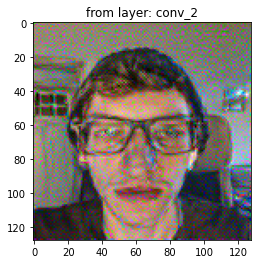

building style transfer model...
total conv layers:16
optimizing...


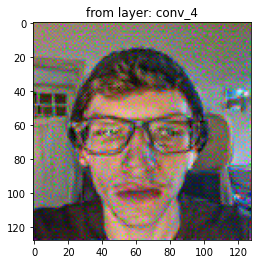

building style transfer model...
total conv layers:16
optimizing...


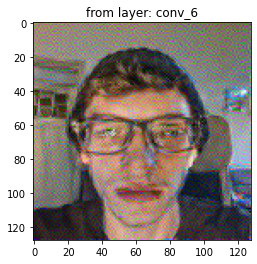

building style transfer model...
total conv layers:16
optimizing...


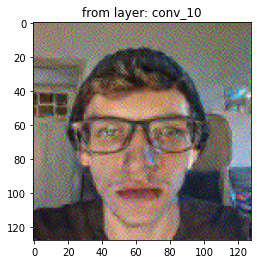

building style transfer model...
total conv layers:16
optimizing...


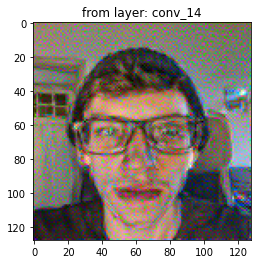

In [143]:
conv_layers_to_test = ['conv_2', 'conv_4', 'conv_6', 'conv_10', 'conv_14']
img_size = 128, 128
loader = transforms.Compose([
    transforms.Resize(img_size), # scale to the correct image size
    transforms.ToTensor()])
content_img = image_loader('./images/sasha.jpg')
style_img = image_loader('./images/picasso2.jpg')
print(content_img.size())
for layer in conv_layers_to_test:
    content_layers_def = [layer]
    input_img = torch.randn(content_img.size(), device=device)
    output = run_style_transfer(cnn, cnn_norm_mean, cnn_norm_std,
                           content_img, style_img, input_img,
                           num_steps=1000, style_over_cont_ratio=0, iters_to_show=10000)
    plt.figure()
    imshow(output, title=f'from layer: {layer}')

In [ ]:
output = run_style_transfer(cnn, cnn_norm_mean, cnn_norm_std,
                           content_img, style_img, input_img,
                           num_steps=1000, style_over_cont_ratio=1e7)